In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import tensorflow as tf

In [2]:
np.random.seed(101)
tf.set_random_seed(101)

## Helper function

In [3]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        """Create a sin(x) dataset"""
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points

        # Dataset
        self.X = np.linspace(xmin, xmax, num_points)
        self.y = np.sin(self.X)


    def ret_true(self, x_series):
        return np.sin(x_series)


    def next_batch(self, batch_size, steps, return_batch_ts=False):
        """Randomly Grab a batch on the sine dataset"""
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1) 

        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )

        # Create batch Time Series on t axis
        X_batch = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(X_batch)

        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), \
                y_batch[:, 1:].reshape(-1, steps, 1), \
                X_batch
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), \
                y_batch[:, 1:].reshape(-1, steps, 1)

## Dataset
- Predict a time series shifted 1 unit into future

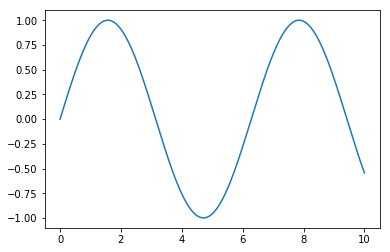

In [4]:
data = TimeSeriesData(
    num_points=250,
    xmin=0,
    xmax=10)

plt.plot(
    data.X,
    data.y)

#### A trainning batch Example

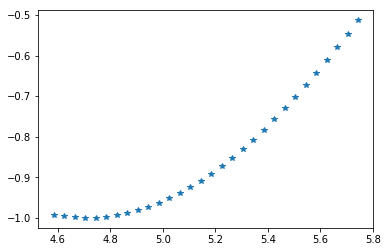

In [5]:
y_batch_t, y_batch_t_plus_1, X_batch = data.next_batch(
    batch_size=1,
    steps=30,
    return_batch_ts=True)

plt.plot(
    X_batch.flatten()[1:],
    y_batch_t_plus_1.flatten(),
    '*')

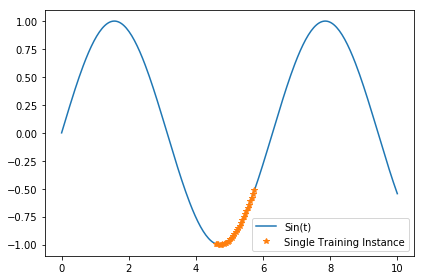

In [6]:
plt.plot(
    data.X,
    data.y,
    label='Sin(t)')

plt.plot(
    X_batch.flatten()[1:],
    y_batch_t_plus_1.flatten(),
    '*',label='Single Training Instance')

plt.legend()
plt.tight_layout()

## Model

#### RNN cells

In [7]:
# Neuron per layer
num_neurons = 100

# Number of layers
n_layers = 3

# Just one feature, the time series
num_inputs = 1

# Just one output, predicted time series
num_outputs = 1

In [8]:
# Basic RNN cell

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(
        num_units=num_neurons,
        activation=tf.nn.relu),
    output_size=num_outputs)

In [9]:
# Basic LSTM cell

# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(
#         num_units=num_neurons,
#         activation=tf.nn.relu),
#     output_size=num_outputs)

In [10]:
# Deep RNN

# cell = tf.contrib.rnn.MultiRNNCell(
#     [tf.contrib.rnn.BasicRNNCell(num_units=num_neurons) for layer in range(n_layers)])

In [11]:
# cell = tf.contrib.rnn.BasicLSTMCell(
#     num_units=num_neurons,
#     activation=tf.nn.relu)

In [12]:
# Deep LSTM

# cell = tf.contrib.rnn.MultiRNNCell(
#     [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons) for layer in range(n_layers)])

#### Constants

In [13]:
# Time step
num_time_steps = 30

# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001

# Size of the batch of data
batch_size = 1

In [14]:
# Placeholders
X_ph = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y_ph = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [15]:
# Dynamic RNN cell
outputs, states = tf.nn.dynamic_rnn(cell, X_ph, dtype=tf.float32)

# loss function
loss = tf.reduce_mean(tf.square(outputs - y_ph)) # MSE

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Trainning function
train = optimizer.minimize(loss)

In [16]:
# init global var
init = tf.global_variables_initializer()

# saver
saver = tf.train.Saver()

with tf.Session() as sess:
    # init global var
    sess.run(init)
    
    for iteration in range(2001):
        
        X_batch, y_batch = data.next_batch(batch_size, num_time_steps)
        sess.run(
            train,
            feed_dict={
                X_ph: X_batch,
                y_ph: y_batch})
        
        if iteration % 200 == 0:
            mse = loss.eval(
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./model/rnn_time_series_model")

0 	MSE: 0.35770273
200 	MSE: 0.046146344
400 	MSE: 0.022381168
600 	MSE: 0.02095514
800 	MSE: 0.0047747777
1000 	MSE: 0.013372599
1200 	MSE: 0.008562952
1400 	MSE: 0.011215912
1600 	MSE: 0.0017518747
1800 	MSE: 0.0022731088
2000 	MSE: 0.0033351348


## Predict timeseries + 1

In [17]:
pred_inst = np.linspace(5, 5 + data.resolution * (30 + 1), 30+1)

In [18]:
with tf.Session() as sess:                          
    saver.restore(sess, "./model/rnn_time_series_model")   

    X_new = np.sin(np.array(pred_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(
        outputs, 
        feed_dict={
            X_ph: X_new})

INFO:tensorflow:Restoring parameters from ./model/rnn_time_series_model


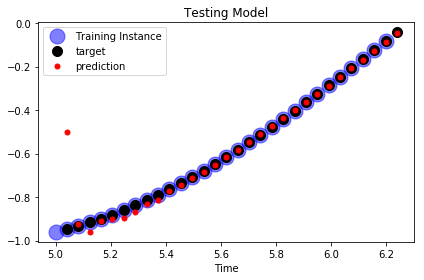

In [19]:
plt.title("Testing Model")

# Training Instance
plt.plot(
    pred_inst[:-1],
    np.sin(pred_inst[:-1]),
    "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(
    pred_inst[1:],
    np.sin(pred_inst[1:]),
    "ko", markersize=10, label="target")

# Models Prediction
plt.plot(
    pred_inst[1:],
    y_pred[0,:,0], 
    "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

## Generating new sequence

#### Train with zeros

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "./model/rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]

    for iteration in range(len(data.X) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(
            outputs, 
            feed_dict={
                X_ph: X_batch})
        
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./model/rnn_time_series_model


Text(0,0.5,'Value')

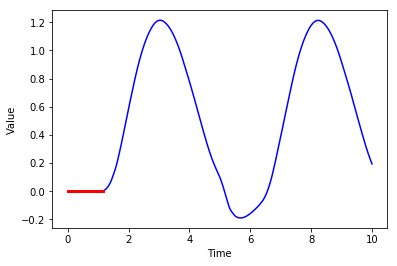

In [21]:
plt.plot(
    data.X,
    zero_seq_seed, "b-")

plt.plot(
    data.X[:num_time_steps],
    zero_seq_seed[:num_time_steps],
    "r", linewidth=3)

plt.xlabel("Time")
plt.ylabel("Value")

#### Train with a part of data

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./model/rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(data.y[:30])

    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(
            outputs,
            feed_dict={
                X_ph: X_batch})

        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./model/rnn_time_series_model


Text(0.5,0,'Time')

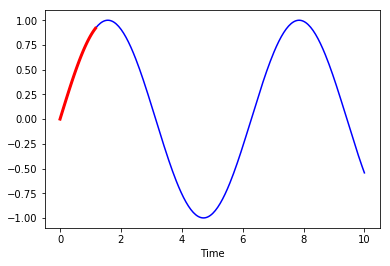

In [23]:
plt.plot(
    data.X,
    data.y,
    "b-")

plt.plot(
    data.X[:num_time_steps],
    training_instance[:num_time_steps], 
    "r-", linewidth=3)

plt.xlabel("Time")